# MFUZZ ANALYSIS - TIMECOURSE IPSC DIFFERENTIATION - RNASEQ (FINAL)

mFuzz clusters genes based on their temporal time pattern. The RNAseq data used for this analysis has been preprocessed to exclude chrX and chrY genes, as well as genes that are not >2 TPM in over 10 samples. 

In [1]:
library(Mfuzz)
library(ggplot2)
library(tidyr)
library(ggrepel)
library(reshape2)

Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which.min

Welcome to Bioconductor

    

# Load data

In [51]:
# Load and read data (Data has already been filtered to exclude chrX and chrY genes, and those with less than <2TMM in more than 35 samples
file = '/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/ppc_expression_binpseudo20.txt'
data = read.table(file)
data = as.matrix(data)

In [52]:
# Relabel and reorder columns
time = c()
labels = c()
for (i in (1:20)) {
    time = c(time, paste0('time_', i))
    labels = c(labels, i)
}

data = data[,time]

In [18]:
head(data)

,time_1,time_2,time_3,time_4,time_5,time_6,time_7,time_8,time_9,time_10,time_11,time_12,time_13,time_14,time_15,time_16,time_17,time_18,time_19,time_20
5S-rRNA.4,0.000000000,0.000000000,0.000000e+00,0.0000000000,0.0001538870,0.0002693807,0.000000000,0.000000000,0.0000000000,0.000000000,0.000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.000000e+00,0.0000000000,0.0000000000
7SK,0.004255691,0.000000000,0.000000e+00,0.0000000000,0.0010600390,0.0004306317,0.000000000,0.000000000,0.0005214258,0.001682241,0.001008553,0.0008643413,0.0005886179,0.0005619345,0.0007551533,0.0007938687,0.0003019040,8.223450e-04,0.0004572753,0.0004576075
7SK.2,0.000000000,0.000000000,0.000000e+00,0.0000000000,0.0006816664,0.0000000000,0.000000000,0.000476418,0.0000000000,0.000000000,0.000000000,0.0001194262,0.0000000000,0.0002037061,0.0001339051,0.0000000000,0.0002751738,0.000000e+00,0.0000000000,0.0003804793
7SK.3,0.000000000,0.000000000,8.178159e-05,0.0001633231,0.0005307031,0.0000000000,0.000000000,0.000000000,0.0002184152,0.000000000,0.000000000,0.0000000000,0.0000000000,0.0000000000,0.0001196640,0.0005282471,0.0000000000,5.467794e-05,0.0003159908,0.0000000000
7SK.4,0.000000000,0.000000000,1.573367e-03,0.0018981460,0.0034126390,0.0011530010,0.002561852,0.003498783,0.0031210400,0.002487561,0.001404842,0.0022023300,0.0025259470,0.0028854060,0.0028480350,0.0018738340,0.0033046650,2.205939e-03,0.0026811880,0.0023671360
A1BG,0.008446700,0.002752256,1.026081e-02,0.0118918641,0.0094752540,0.0123974400,0.014381964,0.008888876,0.0093824480,0.010499010,0.009406580,0.0081045550,0.0112722300,0.0067334640,0.0088720780,0.0083063680,0.0067737050,5.692635e-03,0.0066958730,0.0059834690


In [38]:
nrow(data)

[1] 34908

# Functions

In [39]:
## Calculate mean expression for each time point

meanExp <- function(data){
    # Create new df
    df <- data.frame(matrix(ncol=5, nrow=nrow(data)))
    names(df) =c('d0', 'd2', 'd5', 'd9', 'd15')
    row.names(df)=row.names(data)
    # Calculate mean expression for each time point
    df$d0 <- rowMeans(data[,1:3])
    df$d2 <- rowMeans(data[,4:6])
    df$d5 <- rowMeans(data[,7:9])
    df$d9 <- rowMeans(data[,10:12])
    df$d15 <- rowMeans(data[,13:15])
    df.m <- as.matrix(df)
    return(df.m)
}

mFuzz <- function(matrix, numCluster, dim, acore){
    # Convert to ExpressionSet object
    eset <- ExpressionSet(matrix)

    # Filter out genes with standard deviation of 0
    eset_tmp <- filter.std(eset,min.std=0,visu=TRUE)
    
    # Standardize data (mean = 0, sd = 1)
    eset.s <- standardise(eset_tmp)
    
    # Estimate m to use
    mest <- mestimate(eset.s)
    
    # Implement mfuzz
    c1 <- mfuzz(eset.s, c=numCluster, m=mest)
    #acore(eset.s,c1,min.acore=acore)

    # Visualize clusters produced by mfuzz
    #mfuzz.plot(eset.s, c1, mfrow=c(dim[1],dim[2]), time.labels=c(0,2,5,9,15), new.window=FALSE) 
    mfuzz.plot2(eset.s, c1, mfrow=c(dim[1], dim[2]), time.labels=labels, ylim.set=c(-5,5), x11=FALSE)
    
    return(c1)
}

membershipDF <- function(mFuzzC){
    memberships <- as.data.frame(mFuzzC$membership)
    head(memberships)
    memberships$gene_id <- row.names(memberships)
    memberships <- memberships[order(memberships$gene_id),]
    genecode <- genecode[order(genecode$gene_id),]
    memberships$gene_name <- genecode$gene_name[genecode$gene_id %in% memberships$gene_id]
    memberships <- memberships[c('gene_id', 'gene_name', 1:16)]
    row.names(memberships) <- c()
    colnames(memberships) <- c('gene_id', 'gene_name', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16')
    return(memberships)
}

makeOneCluster <- function(memC){
    clusters <- c()
    mems <- c()
    oneCluster <- data.frame('gene_id' = memC$gene_id, 'gene_name'=memC$gene_name)
    for (i in 1:nrow(memC)){
        row <- as.vector(memC[i,3:ncol(memC)])
        index <- which(row==max(row))
        clusters <- c(clusters, index)
        mems <- c(mems, row[index])
    }
    oneCluster$cluster <- clusters
    oneCluster$membership <- mems
    return(oneCluster)
}

grabClusters2 <- function(gene_names, mem_C, numRow){
    checkDf <- data.frame('index' = 1:numRow)
    nrow(checkDf)
    clusters <- c()
    mems <- c()
    genes <- c()
    for (g in gene_names){
        row <- mem_C[mem_C[,'gene_name'] == as.character(g),]
        b <- row[,3:ncol(mem_C)]
        for (a in 1:nrow(b)){
            genes <- c(genes, g)
            r <- as.vector(b[a,]) # For each row
            clusters <- c(clusters, which(r == max(r))) # Get position of max membership
            mems <- c(mems, max(r))  
        }
    }
    checkDf$gene_names <- genes
    checkDf$cluster <- clusters
    checkDf$membership <- mems
    return(checkDf)  
}


grabClusters_unique <- function(gene_names, mem_C, numRow){
    checkDf <- data.frame('index' = 1:numRow)
    clusters <- c()
    mems <- c()
    genes <- c()
    for (g in gene_names){
        row <- mem_C[mem_C[,'gene_name'] == as.character(g),]
        b <- row[,3:ncol(mem_C)]
        for (a in 1:nrow(b)){
            genes <- c(genes, g)
            r <- as.vector(b[a,]) # For each row
            clusters <- c(clusters, which(r == max(r))) # Get position of max membership
            mems <- c(mems, max(r))  
        }
    }
    checkDf$gene_names <- genes
    checkDf$cluster <- clusters
    checkDf$membership <- mems
    return(checkDf)
    
}

# Run mFuzz

In [36]:
getwd()

[1] "/frazer01/home/jennifer/references/cardips/RNAseq/analysis/mfuzz"

0 genes excluded.


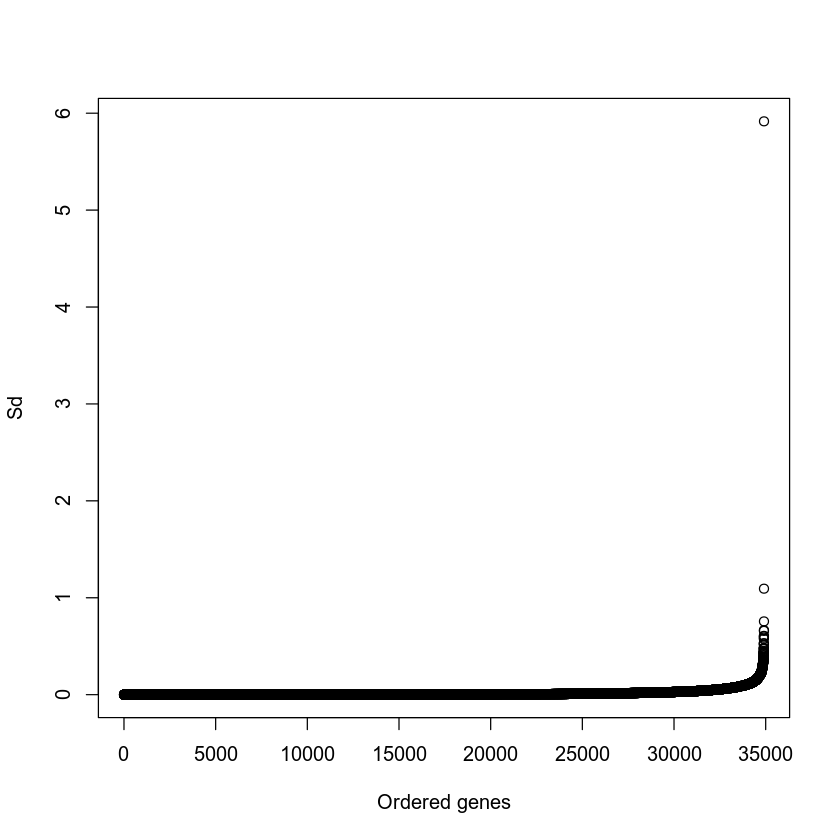

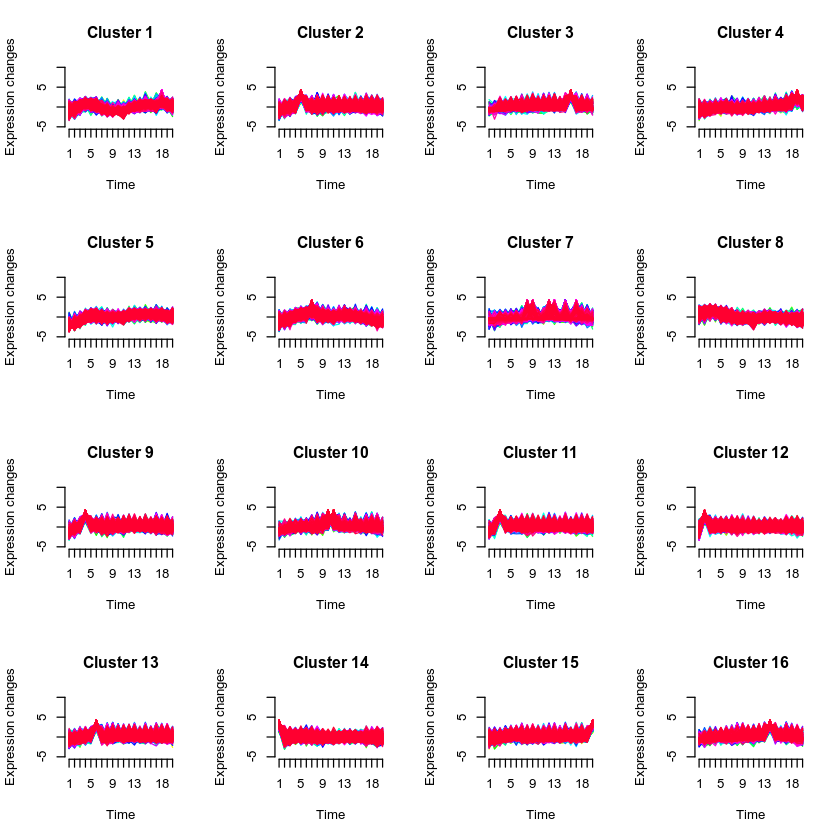

In [32]:
pdf("plot.pdf")
mfuzzOut <- mFuzz(data, 16, c(4, 4), 0.7)
dev.off()

## Save Membership Matrix

In [33]:
save(mfuzzOut, file="/frazer01/home/jennifer/references/PPCs/mfuzz/out.robj")

## Time: 1, 4, 8, 12, 16, 20

4565 genes excluded.


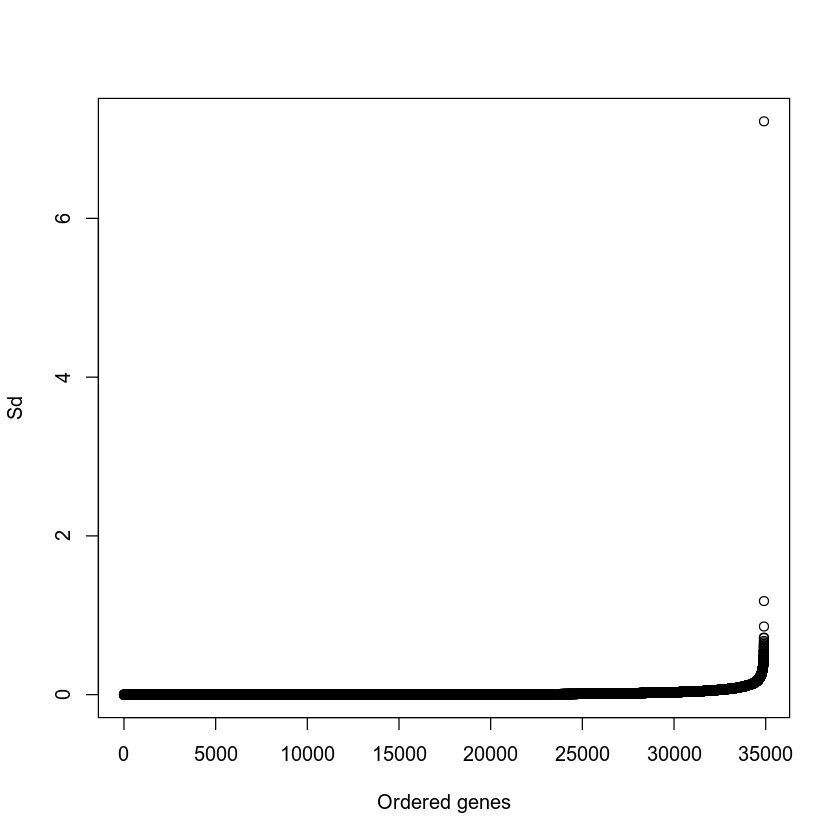

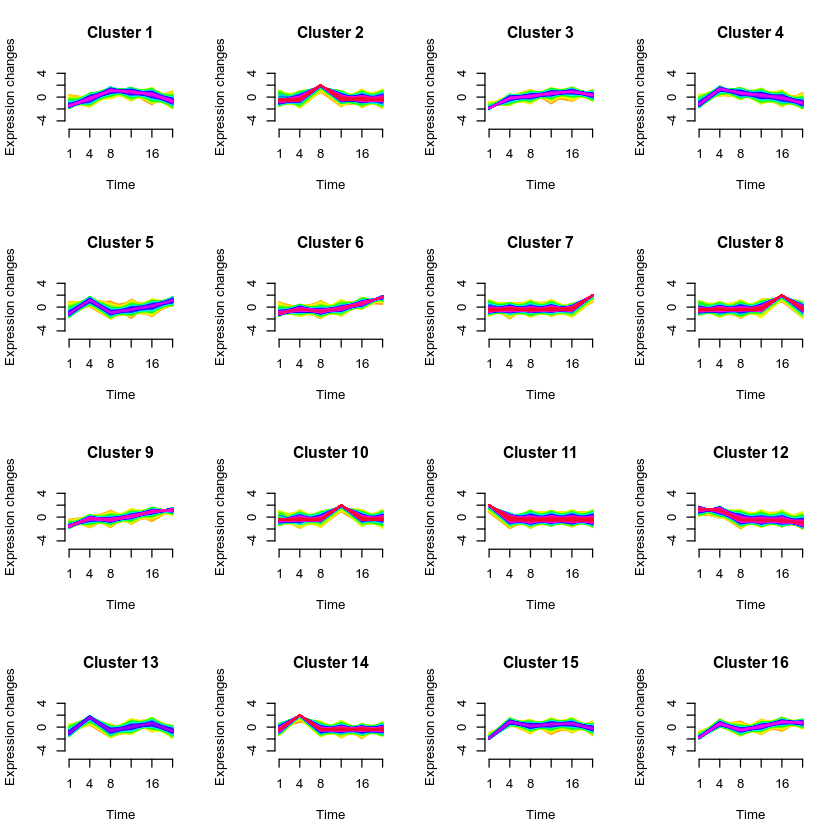

In [57]:
less =data[,c("time_1", "time_4", "time_8", "time_12", "time_16", "time_20")]
labels = c(1,4,8,12,16,20)
mfuzzOut <- mFuzz(less, 16, c(4, 4), 0.7)

## Times 1-10

3098 genes excluded.


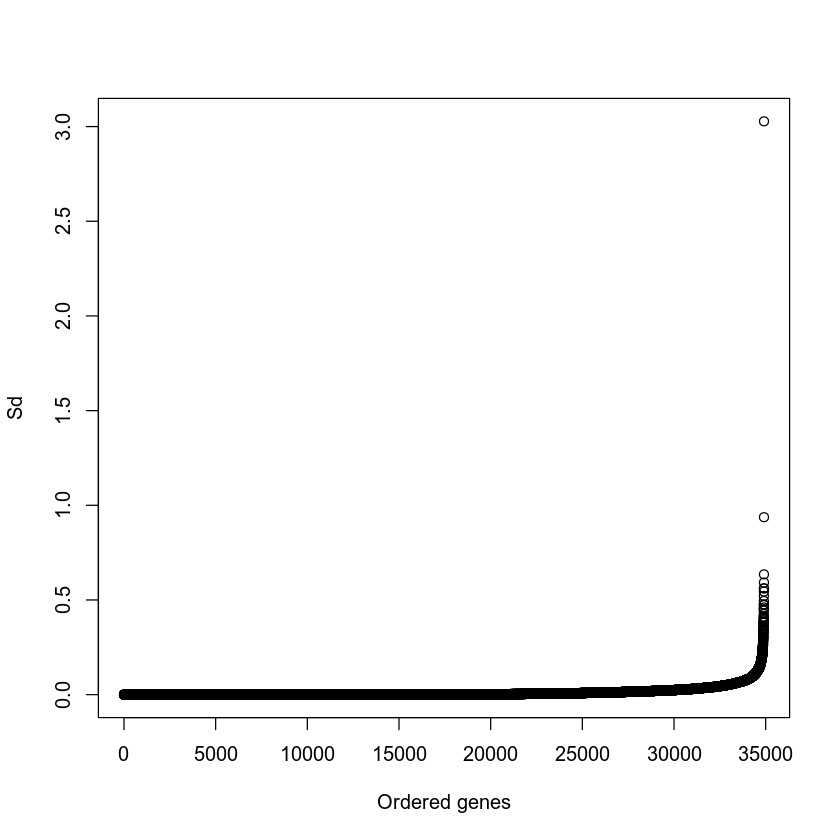

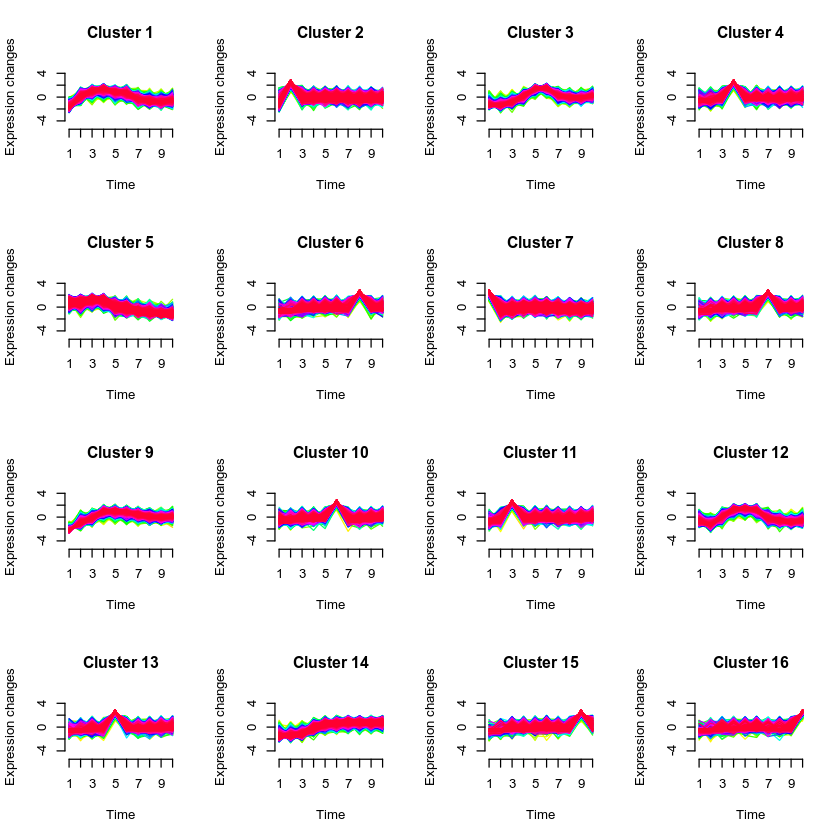

In [59]:
less =data[,c("time_1", "time_2", "time_3", "time_4", "time_5", "time_6", "time_7", "time_8", "time_9", "time_10")]
labels = (1:10)
mfuzzOut <- mFuzz(less, 16, c(4, 4), 0.7)

## Times 11-20

1914 genes excluded.


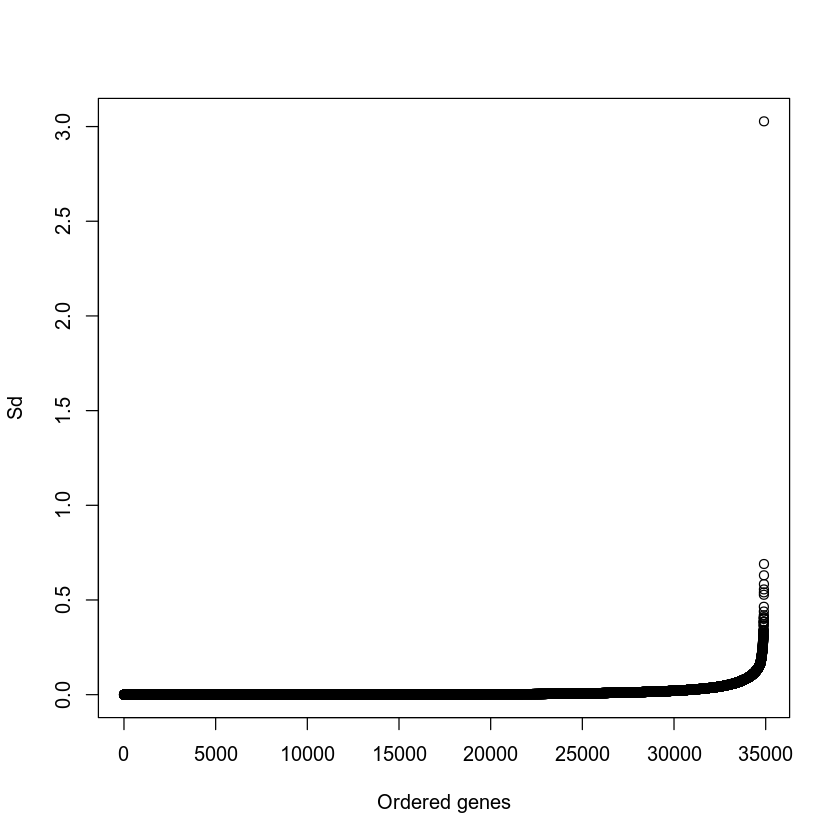

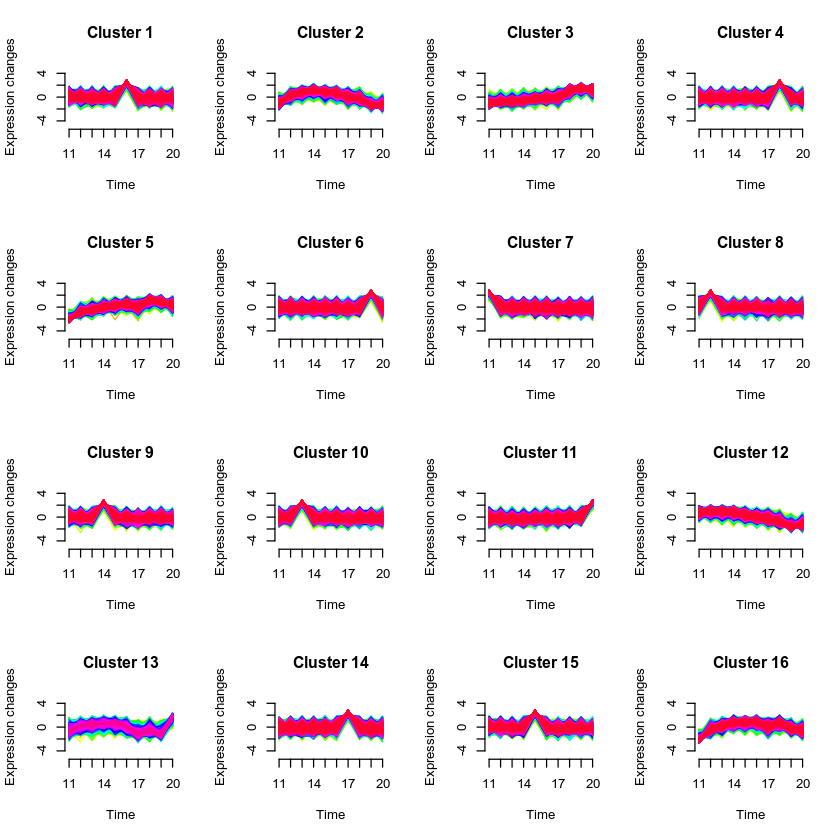

In [60]:
less =data[,c("time_11", "time_12", "time_13", "time_14", "time_15", "time_16", "time_17", "time_18", "time_19", "time_20")]
labels = (11:20)
mfuzzOut <- mFuzz(less, 16, c(4, 4), 0.7)

## Larger bins

In [63]:
# Load and read data (Data has already been filtered to exclude chrX and chrY genes, and those with less than <2TMM in more than 35 samples
file = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/ppc_expression_binpseudo10.txt"
data = read.table(file)
data = as.matrix(data)

# Relabel and reorder columns
time = c()
labels = c()
for (i in (1:10)) {
    time = c(time, paste0('time_', i))
    labels = c(labels, i)
}

data = data[,time]

1914 genes excluded.


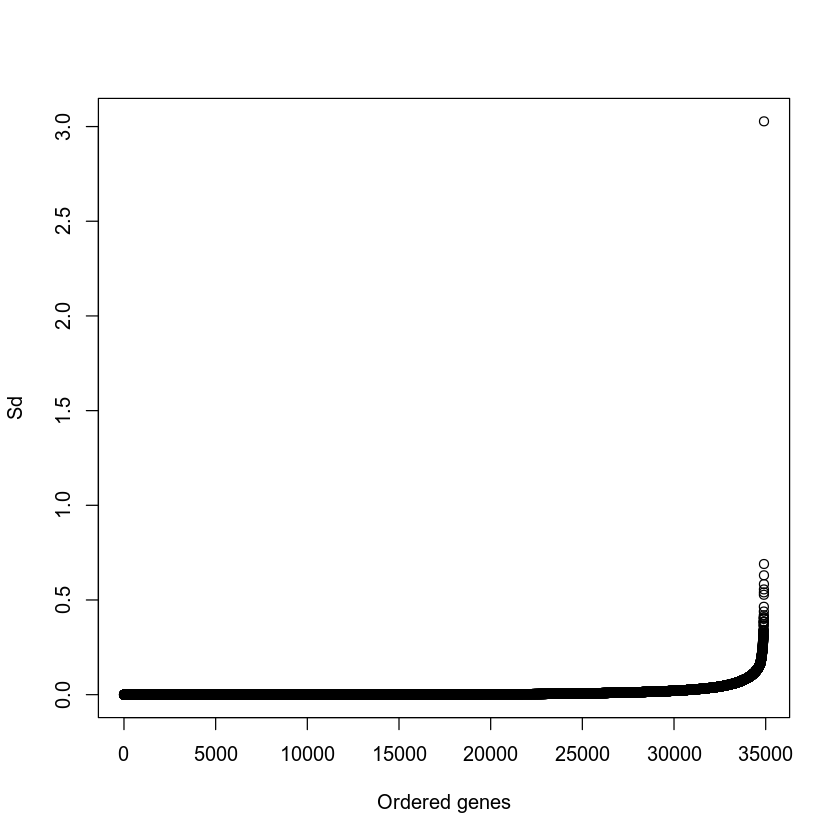

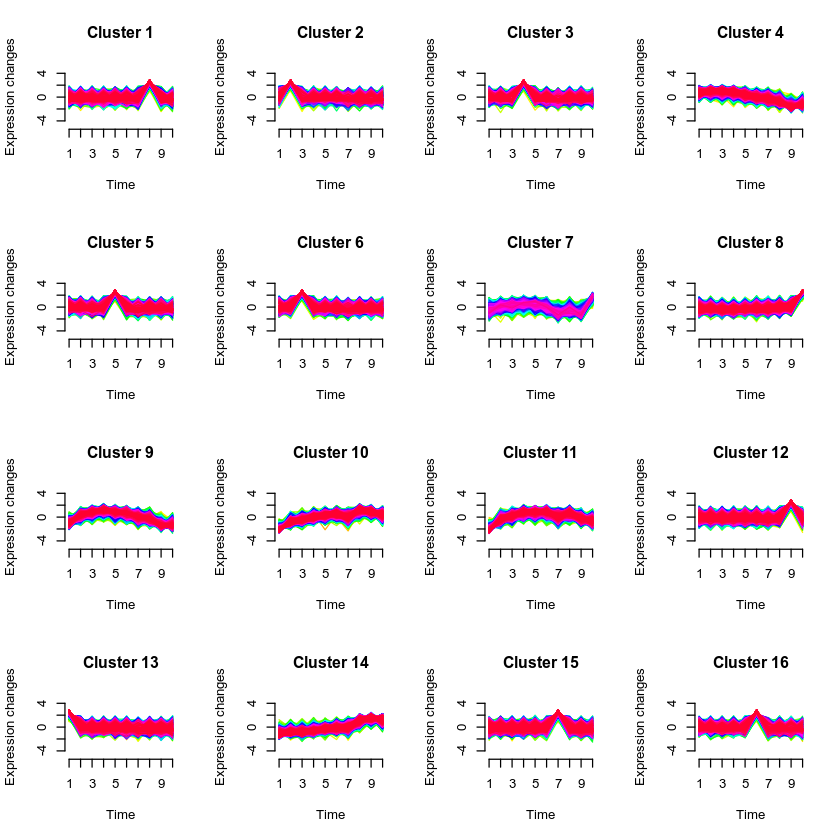

In [64]:
mfuzzOut <- mFuzz(less, 16, c(4, 4), 0.7)
save(mfuzzOut, file="/frazer01/home/jennifer/references/PPCs/mfuzz/out_10timepoints.robj")